In [1]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [17]:
IMAGE_SIZE = [224, 224]

train_path = r'/Users/hexue/pyproject/retina_classification/Retinal Fundus Images/train'
test_path = r'/Users/hexue/pyproject/retina_classification/Retinal Fundus Images/test'
val_path = r'/Users/hexue/pyproject/retina_classification/Retinal Fundus Images/val'

In [3]:
base_model= tf.keras.applications.EfficientNetB4(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False, pooling='max')

In [6]:
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(11, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
#for windows
#model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])
#for mac
model.compile(tf.keras.optimizers.legacy.Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    print(y_true)
    print(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [18]:
train_datagen = ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(directory=train_path,
target_size = (224,224),
batch_size = 32,
class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(directory=test_path,
target_size = (224,224),
batch_size = 32,
class_mode = 'categorical')
val_set = test_datagen.flow_from_directory(directory=val_path,
target_size = (224,224),
batch_size = 32,
class_mode = 'categorical')

Found 20077 images belonging to 11 classes.
Found 1236 images belonging to 11 classes.
Found 433 images belonging to 11 classes.


2023-12-13 17:01:56.793664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-13 17:01:56.835896: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 2s 2s/step
          Filename                Predicted Class                True Class           Probability   

1.Dry AMD/Dry AMD102_left_0_9315.jpeg 8.Hypertensive Retinopathy          1.Dry AMD              0.4163

1.Dry AMD/Dry AMD102_left_0_9315.jpeg 8.Hypertensive Retinopathy 1.Dry AMD 0.41627464
1.Dry AMD/Dry AMD102_left_0_9943.jpeg        5.Severe DR                  1.Dry AMD              0.3857

1.Dry AMD/Dry AMD102_left_0_9943.jpeg 5.Severe DR 1.Dry AMD 0.38565284
1.Dry AMD/Dry AMD102_right_0_116.jpeg        5.Severe DR                  1.Dry AMD              0.6508

1.Dry AMD/Dry AMD102_right_0_116.jpeg 5.Severe DR 1.Dry AMD 0.6507956
1.Dry AMD/Dry AMD102_right_0_3112.jpeg        5.Severe DR                  1.Dry AMD              0.5810

1.Dry AMD/Dry AMD102_right_0_3112.jpeg 5.Severe DR 1.Dry AMD 0.58101606
1.Dry AMD/Dry AMD102_right_0_4731.jpeg        5.Severe DR                  1.Dry AMD              0.6203

1.Dry AMD/Dry AMD102_r

ValueError: Found input variables with inconsistent numbers of samples: [1236, 32]

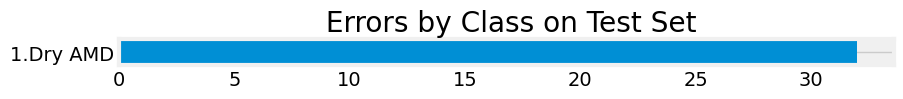

In [19]:
import os
from sklearn.metrics import confusion_matrix, classification_report
length=len(test_set)
subject='eye disease'
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
working_dir = r'./'
print_code=10
preds=model.predict(test_set, steps=test_steps, verbose=1) 
print_info( test_set, preds, print_code, working_dir, subject )  


In [20]:
model.predict(test_set)


2023-12-13 17:02:16.408569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


39/39 [==============================] - 35s 891ms/step


NameError: name 'lt' is not defined

In [ ]:
m = model.fit(
  training_set,
  validation_data=val_set,
  epochs=20,
  batch_size=128,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  shuffle=False,
  initial_epoch=0
)
plt.plot(m.history['loss'], label='Train loss')
plt.plot(m.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(m.history['accuracy'], label='Train Accuracy')
plt.plot(m.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

Epoch 1/20


2023-12-13 17:04:13.180078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  2/628 [..............................] - ETA: 3:41:36 - loss: 11.7404 - accuracy: 0.0469